# Case Study - Collared Floater

# Introduction

A **collared floater** pays a floating-rate coupon bounded by a floor and a cap:

$$\max(K_{\text{floor}},\; \min(r,\; K_{\text{cap}}))$$

It can be replicated with three instruments:

| Instrument | Position |
|------------|----------|
| Floating-rate note | +1 |
| Floor (strike = $K_{\text{floor}}$) | +1 |
| Cap (strike = $K_{\text{cap}}$) | -1 |

# Setup


In [1]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy.optimize import fsolve
from scipy.stats import norm

# Data

Use the data from the following file.
* `../data/fiderivs_2025-03-10.xlsx`

In [2]:
DATE = '2025-03-10'
FILEIN = f'fiderivs_{DATE}.xlsx'

curves = pd.read_excel(FILEIN, sheet_name='rate curves').set_index('tenor')
curves.style.format('{:.1%}').format_index('{:.2f}')

,swap rates,spot rates,discounts,forwards,flat vols
tenor,,,,,
0.25,4.2%,4.2%,99.0%,nan%,nan%
0.50,4.1%,4.1%,98.0%,4.0%,14.6%
0.75,4.0%,4.0%,97.1%,3.7%,16.9%
1.00,3.9%,3.9%,96.2%,3.6%,19.1%
1.25,3.8%,3.8%,95.4%,3.4%,22.2%
1.50,3.7%,3.7%,94.6%,3.4%,24.5%
1.75,3.7%,3.7%,93.8%,3.4%,26.1%
2.00,3.7%,3.7%,93.0%,3.5%,27.2%
2.25,3.6%,3.6%,92.2%,3.4%,27.9%


### Parameters


In [3]:
NOTIONAL = 100
T = 5                   # Maturity in years
CPNFREQ = 4             # Quarterly coupons
FREQ_CURVE = 4          # Quarterly compounding

BOUND_LOWER = 0.02      # 2% floor
BOUND_UPPER = 0.05      # 5% cap

# 1. Pricing the Components


### 1.1.

A floater with no credit spread trades at par. Record the floater value.

In [4]:
FLOATER_VALUE = NOTIONAL

### 1.2.

Price the **floor** (strike = 2%) and the **cap** (strike = 5%).

Use the flat vol at the 5-year tenor from the `curves` table.

Report both prices.

In [5]:
# Uses np + norm imported in the Setup cell

def _black_call_rate(fwd: float, strike: float, vol: float, texp: float) -> float:
    if texp <= 0 or vol <= 0:
        return max(fwd - strike, 0.0)
    if fwd <= 0 or strike <= 0:
        return 0.0
    vsqrt = vol * np.sqrt(texp)
    d1 = (np.log(fwd / strike) + 0.5 * vsqrt * vsqrt) / vsqrt
    d2 = d1 - vsqrt
    return fwd * norm.cdf(d1) - strike * norm.cdf(d2)

def _black_put_rate(fwd: float, strike: float, vol: float, texp: float) -> float:
    if texp <= 0 or vol <= 0:
        return max(strike - fwd, 0.0)
    if fwd <= 0 or strike <= 0:
        return 0.0
    vsqrt = vol * np.sqrt(texp)
    d1 = (np.log(fwd / strike) + 0.5 * vsqrt * vsqrt) / vsqrt
    d2 = d1 - vsqrt
    return strike * norm.cdf(-d2) - fwd * norm.cdf(-d1)

def shock_dfs_parallel(dfs_in: np.ndarray, tenors_in: np.ndarray, dy: float) -> np.ndarray:
    """Parallel shift to (continuous) spot rates: DF(t) -> DF(t) * exp(-dy * t)."""
    return dfs_in * np.exp(-dy * tenors_in)

def cap_floor_price_black_from_dfs(
    dfs_in: np.ndarray,
    strike_floor: float,
    strike_cap: float,
    vol: float,
    notional: float,
    coupon_freq: int,
    *,
    reset_offset: float = 0.0,
 ) -> tuple[float, float]:
    """Returns (floor_value, cap_value) using Black on forwards implied by discount factors."""
    tau_local = 1.0 / coupon_freq
    df_prev_local = np.r_[1.0, dfs_in[:-1]]
    fwds_local = (df_prev_local / dfs_in - 1.0) / tau_local
    texps_local = reset_offset + np.arange(len(dfs_in)) * tau_local  # reset times t0, t1, ..., t_{n-1}

    caplets = np.array([_black_call_rate(f, strike_cap, vol, t) for f, t in zip(fwds_local, texps_local)])
    floorlets = np.array([_black_put_rate(f, strike_floor, vol, t) for f, t in zip(fwds_local, texps_local)])

    cap_value = float(notional * np.sum(dfs_in * tau_local * caplets))
    floor_value = float(notional * np.sum(dfs_in * tau_local * floorlets))
    return floor_value, cap_value

def mod_duration(p0: float, pup: float, pdn: float, dy: float) -> float:
    return float(-(pup - pdn) / (2.0 * p0 * dy)) if p0 != 0 else np.nan

# Inputs from the notebook
tau = 1.0 / CPNFREQ
tenors = np.round(np.arange(tau, T + 1e-12, tau), 10)

# Use the 5Y flat vol (constant across caplets/floorlets)
flat_vol_5y = float(curves.loc[float(T), 'flat vols'])

# Discount factors at each payment date
dfs = curves['discounts'].reindex(tenors).to_numpy(dtype=float)
if np.isnan(dfs).any():
    missing = tenors[np.isnan(dfs)]
    raise ValueError(f"Missing discount factors for tenors: {missing}")

FLOOR_STRIKE = BOUND_LOWER  # 2%
CAP_STRIKE = BOUND_UPPER    # 5%

FLOOR_VALUE, CAP_VALUE = cap_floor_price_black_from_dfs(
    dfs,
    strike_floor=FLOOR_STRIKE,
    strike_cap=CAP_STRIKE,
    vol=flat_vol_5y,
    notional=NOTIONAL,
    coupon_freq=CPNFREQ,
 )

print(f"Using flat vol @ {T}Y: {flat_vol_5y:.4%}")
print(f"Floor (K={FLOOR_STRIKE:.2%}) price: {FLOOR_VALUE:.4f}")
print(f"Cap   (K={CAP_STRIKE:.2%}) price: {CAP_VALUE:.4f}")

Using flat vol @ 5Y: 28.0916%
Floor (K=2.00%) price: 0.2449
Cap   (K=5.00%) price: 0.9773


### 1.3.

Combine the three instruments into the replicating portfolio:
* +1 Floater
* +1 Floor (2%)
* -1 Cap (5%)

Report the NAV of each component and the total portfolio value.

Is the portfolio worth more or less than par? Why?


In [6]:
nav = pd.DataFrame(
    {
        "Position": {
            "Floater": +1,
            f"Floor ({BOUND_LOWER:.0%})": +1,
            f"Cap ({BOUND_UPPER:.0%})": -1,
        },
        "NAV": {
            "Floater": float(FLOATER_VALUE),
            f"Floor ({BOUND_LOWER:.0%})": float(FLOOR_VALUE),
            f"Cap ({BOUND_UPPER:.0%})": float(CAP_VALUE),
        },
    }
)
nav["Contribution"] = nav["Position"] * nav["NAV"]

portfolio_value = float(nav["Contribution"].sum())

display(nav.style.format({"NAV": "{:.4f}", "Contribution": "{:.4f}"}))
print(f"Total replicating portfolio value: {portfolio_value:.4f}")

if portfolio_value > NOTIONAL:
    print("Portfolio is worth MORE than par.")
elif portfolio_value < NOTIONAL:
    print("Portfolio is worth LESS than par.")
else:
    print("Portfolio is worth AT par.")

,Position,NAV,Contribution
Floater,1,100.0000,100.0000
Floor (2%),1,0.2449,0.2449
Cap (5%),-1,0.9773,-0.9773


Total replicating portfolio value: 99.2676
Portfolio is worth LESS than par.


Portfolio is worth less than par. This indicates that the value of cap is bigger than the value of floor, which means that the market expects the rate to be more likely over the cap than below the floor, or the upper risk is higher than the lower risk.

# 2. Risk Analysis


### 2.1.

Calculate the **duration** of the portfolio numerically by applying a 1bp parallel shock to the spot curve.

Report the duration of each component and the portfolio.

In [7]:
bp = 1e-4  # 1bp shock

required = [
    "dfs",
    "tenors",
    "flat_vol_5y",
    "CAP_STRIKE",
    "FLOOR_STRIKE",
    "CAP_VALUE",
    "FLOOR_VALUE",
    "FLOATER_VALUE",
    "shock_dfs_parallel",
    "cap_floor_price_black_from_dfs",
    "mod_duration",
 ]
missing = [name for name in required if name not in globals()]
if missing:
    raise NameError(f"Run the earlier cells first; missing: {missing}")

dfs_up = shock_dfs_parallel(dfs, tenors, +bp)
dfs_dn = shock_dfs_parallel(dfs, tenors, -bp)

floor_up, cap_up = cap_floor_price_black_from_dfs(
    dfs_up,
    strike_floor=FLOOR_STRIKE,
    strike_cap=CAP_STRIKE,
    vol=flat_vol_5y,
    notional=NOTIONAL,
    coupon_freq=CPNFREQ,
 )
floor_dn, cap_dn = cap_floor_price_black_from_dfs(
    dfs_dn,
    strike_floor=FLOOR_STRIKE,
    strike_cap=CAP_STRIKE,
    vol=flat_vol_5y,
    notional=NOTIONAL,
    coupon_freq=CPNFREQ,
 )

# Floater stays at par under the simplifying assumption in 1.1 (no credit spread; par floater)
floater_up = float(FLOATER_VALUE)
floater_dn = float(FLOATER_VALUE)

port_0 = float(FLOATER_VALUE + FLOOR_VALUE - CAP_VALUE)
port_up = float(floater_up + floor_up - cap_up)
port_dn = float(floater_dn + floor_dn - cap_dn)

dur = pd.DataFrame(
    {
        "Price": {
            "Floater": float(FLOATER_VALUE),
            f"Floor ({FLOOR_STRIKE:.0%})": float(FLOOR_VALUE),
            f"Cap ({CAP_STRIKE:.0%})": float(CAP_VALUE),
            "Portfolio": port_0,
        },
        "Price(+1bp)": {
            "Floater": floater_up,
            f"Floor ({FLOOR_STRIKE:.0%})": floor_up,
            f"Cap ({CAP_STRIKE:.0%})": cap_up,
            "Portfolio": port_up,
        },
        "Price(-1bp)": {
            "Floater": floater_dn,
            f"Floor ({FLOOR_STRIKE:.0%})": floor_dn,
            f"Cap ({CAP_STRIKE:.0%})": cap_dn,
            "Portfolio": port_dn,
        },
    }
)

dur["Duration"] = [
    mod_duration(dur.loc[idx, "Price"], dur.loc[idx, "Price(+1bp)"], dur.loc[idx, "Price(-1bp)"], bp)
    for idx in dur.index
 ]

display(
    dur.style.format(
        {"Price": "{:.4f}", "Price(+1bp)": "{:.4f}", "Price(-1bp)": "{:.4f}", "Duration": "{:.4f}"}
    )
)

,Price,Price(+1bp),Price(-1bp),Duration
Floater,100.0000,100.0000,100.0000,-0.0000
Floor (2%),0.2449,0.2424,0.2475,104.7859
Cap (5%),0.9773,0.9882,0.9665,-110.6356
Portfolio,99.2676,99.2542,99.2809,1.3478


### 2.2.

Calculate the **OAS** of the portfolio.

If the market quotes this note at par (100.00), what parallel shift to the spot curve would match that price?

Use `fsolve` to find the OAS.

In [8]:
TARGET_PRICE = 100.0 

required = [
    "dfs",
    "tenors",
    "flat_vol_5y",
    "CAP_STRIKE",
    "FLOOR_STRIKE",
    "FLOATER_VALUE",
    "shock_dfs_parallel",
    "cap_floor_price_black_from_dfs",
    "fsolve",
 ]
missing = [name for name in required if name not in globals()]
if missing:
    raise NameError(f"Run the earlier cells first; missing: {missing}")

def portfolio_value_with_spread(spread: float) -> float:
    spread = float(np.atleast_1d(spread)[0])
    dfs_s = shock_dfs_parallel(dfs, tenors, spread)
    floor_s, cap_s = cap_floor_price_black_from_dfs(
        dfs_s,
        strike_floor=FLOOR_STRIKE,
        strike_cap=CAP_STRIKE,
        vol=flat_vol_5y,
        notional=NOTIONAL,
        coupon_freq=CPNFREQ,
    )
    floater_s = float(FLOATER_VALUE)  # simplified: par floater assumption
    return float(floater_s + floor_s - cap_s)

def oas_objective(spread: float) -> float:
    return portfolio_value_with_spread(spread) - TARGET_PRICE

oas = float(fsolve(oas_objective, x0=0.0)[0])
price_at_oas = portfolio_value_with_spread(oas)

print(f"OAS (continuous, parallel): {oas * 1e4:.2f} bp")
print(f"Model price at OAS: {price_at_oas:.6f} (target {TARGET_PRICE:.2f})")

OAS (continuous, parallel): -59.35 bp
Model price at OAS: 100.000000 (target 100.00)


### 2.3.

Plot the portfolio value across a range of interest rate scenarios (shock the spot curve from -300bp to +300bp).

On your plot, mark the current rate, the floor (2%), and the cap (5%).

Describe what you see in terms of convexity.

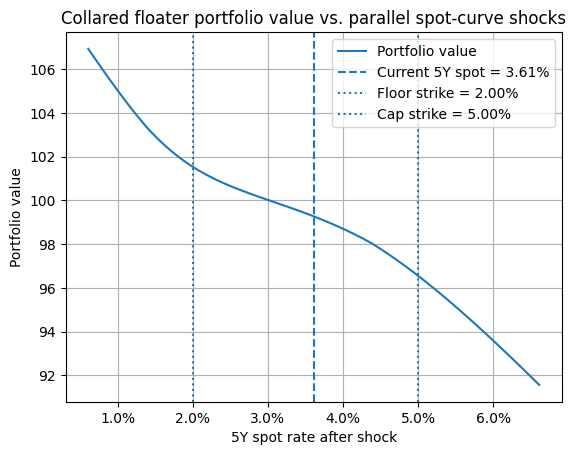

In [9]:
required = [
    "dfs",
    "tenors",
    "flat_vol_5y",
    "FLOOR_STRIKE",
    "CAP_STRIKE",
    "FLOATER_VALUE",
    "shock_dfs_parallel",
    "cap_floor_price_black_from_dfs",
 ]
missing = [name for name in required if name not in globals()]
if missing:
    raise NameError(f"Run the earlier cells first; missing: {missing}")

# Scenario shocks: -300bp ... +300bp
shock_bps = np.arange(-300, 301, 5)
shocks = shock_bps / 1e4  # decimal

# Use 5Y spot rate as the 'current rate' marker on x-axis
current_rate = float(curves.loc[float(T), "spot rates"])
scenario_rates = current_rate + shocks

values = []
for dy in shocks:
    dfs_s = shock_dfs_parallel(dfs, tenors, dy)
    floor_s, cap_s = cap_floor_price_black_from_dfs(
        dfs_s,
        strike_floor=FLOOR_STRIKE,
        strike_cap=CAP_STRIKE,
        vol=flat_vol_5y,
        notional=NOTIONAL,
        coupon_freq=CPNFREQ,
    )
    values.append(float(FLOATER_VALUE + floor_s - cap_s))
values = np.array(values)

plt.figure()
plt.plot(scenario_rates, values, label="Portfolio value")
plt.axvline(current_rate, linestyle="--", label=f"Current 5Y spot = {current_rate:.2%}")
plt.axvline(FLOOR_STRIKE, linestyle=":", label=f"Floor strike = {FLOOR_STRIKE:.2%}")
plt.axvline(CAP_STRIKE, linestyle=":", label=f"Cap strike = {CAP_STRIKE:.2%}")

ax = plt.gca()
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

plt.xlabel("5Y spot rate after shock")
plt.ylabel("Portfolio value")
plt.title("Collared floater portfolio value vs. parallel spot-curve shocks")
plt.legend()
plt.grid(True)
plt.show()

In [10]:
# Find points where convexity (second derivative) crosses zero
required = ["scenario_rates", "values", "current_rate"]
missing = [name for name in required if name not in globals()]
if missing:
    raise NameError(f"Run the 2.3 plot cell first; missing: {missing}")

x = np.asarray(scenario_rates, dtype=float)
y = np.asarray(values, dtype=float)
if x.ndim != 1 or y.ndim != 1 or x.size != y.size or x.size < 5:
    raise ValueError("scenario_rates/values must be 1D arrays of equal length (>=5).")

# Numerical convexity: d2V/dx2
dy_dx = np.gradient(y, x)
d2y_dx2 = np.gradient(dy_dx, x)

# Locate sign changes in convexity
sign = np.sign(d2y_dx2)
sign[sign == 0] = np.nan  # treat exact zeros as missing for sign-change detection
idx = np.where(np.signbit(sign[:-1]) != np.signbit(sign[1:]))[0]

zero_points = []
for i in idx:
    x0, x1 = x[i], x[i + 1]
    c0, c1 = d2y_dx2[i], d2y_dx2[i + 1]
    if not np.isfinite(c0) or not np.isfinite(c1) or c0 == c1:
        continue
    # linear interpolation for c(x)=0
    x_star = x0 - c0 * (x1 - x0) / (c1 - c0)
    zero_points.append(float(x_star))

if not zero_points:
    print("No convexity=0 crossing found on the scenario grid.")
else:
    zero_points = sorted(set(np.round(zero_points, 10)))
    print("Convexity≈0 at (5Y spot after shock):")
    for z in zero_points:
        print(f"  {z:.4%}")
    closest = min(zero_points, key=lambda z: abs(z - float(current_rate)))
    print(f"Closest to current rate ({current_rate:.4%}): {closest:.4%}")

Convexity≈0 at (5Y spot after shock):
  3.0706%
Closest to current rate (3.6100%): 3.0706%


Convexity is positive when rate is low, negative when rate is high. This makes sense because of the influnce of cap and floor.

# 3. Stress Test: A +300bp Shock


In 1994, the Federal Reserve raised rates roughly 300bp in under a year, causing large losses on structured note portfolios — most notably Orange County's $1.7 billion loss.

Orange County held primarily **inverse floaters** (coupon = Fixed Rate $-$ Multiplier $\times$ Floating Rate), which are more aggressive than a collared floater. But it is instructive to see what a +300bp shock does to our product.


### 3.1.

Compute the portfolio value after a +300bp parallel shock to the spot curve.

Report the percentage loss.

In [11]:
shock_bp = 300
dy = shock_bp / 1e4  # +300bp

# We use the par=100 convention: first calibrate OAS in 2.2 so base value is 100, then apply the +300bp shock.
required = ["oas", "portfolio_value_with_spread", "TARGET_PRICE"]
missing = [name for name in required if name not in globals()]
if missing:
    raise NameError("Run 2.2 first to compute OAS (par calibration).")

port_0 = float(TARGET_PRICE)  # par = 100
port_300 = float(portfolio_value_with_spread(oas + dy))
loss_pct = (port_300 / port_0 - 1.0) * 100.0

print(f"Portfolio value (par base): {port_0:.4f}")
print(f"Portfolio value (+{shock_bp}bp): {port_300:.4f}")
print(f"Percentage loss vs par: {loss_pct:.4f}%")

Portfolio value (par base): 100.0000
Portfolio value (+300bp): 93.5288
Percentage loss vs par: -6.4712%


### 3.2.

Orange County's investment pool was leveraged roughly 2.5x.

If we apply the same leverage to the loss from 3.1, what is the leveraged loss?

How does it compare to Orange County's actual 22.3% loss? Why is the gap so large?


In [12]:
LEVERAGE = 2.5

if "loss_pct" not in globals():
    raise NameError("Run 3.1 first to compute loss_pct.")

levered_loss_pct = LEVERAGE * float(loss_pct)
print(f"Levered loss @ {LEVERAGE:.1f}x: {levered_loss_pct:.4f}%")

Levered loss @ 2.5x: -16.1781%


The gap is large might be due to the different portfolio structure. Orange County's investment is more sensitive to large rate spike because it uses multiplier instead of a cap.

# 4. Optional: Volatility Skew

*Requires SABR (Chapter 8).*

### 4.1.

The analysis above uses a single flat vol for both the cap and floor. In practice, implied volatility varies with strike.

Using the SABR parameters below (estimated in `E.8.2. SABR Calibration`), compute the SABR-implied vol at each strike (2% and 5%).

| Parameter | Value |
|-----------|-------|
| beta | 0.25 |
| alpha | 0.0214 |
| nu | 0.60 |
| rho | -0.20 |

Use the 5-year forward rate as the forward.


### 4.2.

Re-price the floor and cap using the SABR-implied vols (one vol per instrument).

Compare the flat-vol portfolio value to the SABR-adjusted portfolio value. Which direction does the skew push the price, and why?


Part 2 (C.9.1) values the same product using binomial trees.